<a href="https://colab.research.google.com/github/rakshithcgowda/Human_AI/blob/main/Text_recognition_with_transformer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 0s (443 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126210 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
!pip install pdf2image

In [3]:
!pip install docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docx: filename=docx-0.2.4-py3-none-any.whl size=53893 sha256=0f012c52ce305710ccce0b07b6143a83cba3a8ec5e2e418c2ee82cd5413f1e30
  Stored in directory: /root/.cache/pip/wheels/c1/3e/c3/e81c11effd0be5658a035947c66792dd993bcff317eae0e1ed
Successfully built docx


In [4]:
# rm -rf /content/jpg_images

#Convert form PDF to JPG

In [ ]:
import os
from PIL import Image
from pdf2image import convert_from_path

def convert_pdf_to_jpg(pdf_dir, jpg_dir, dpi=200):
    """
    Convert PDF files to JPG images. Each page of a PDF will be converted to a separate JPG image.

    Args:
        pdf_dir (str): Directory containing PDF files.
        jpg_dir (str): Directory where the JPG images will be saved.
        dpi (int): Resolution for converting PDF pages.
    """
    if not os.path.exists(jpg_dir):
        os.makedirs(jpg_dir)

    for filename in os.listdir(pdf_dir):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, filename)
            try:
                # Convert PDF pages to images
                pages = convert_from_path(pdf_path, dpi=dpi)
                for i, page in enumerate(pages):
                    jpg_filename = os.path.splitext(filename)[0] + f"_page{i+1}.jpg"
                    jpg_path = os.path.join(jpg_dir, jpg_filename)
                    page.save(jpg_path, "JPEG")
                    print(f"Saved JPG image to {jpg_path}")
            except Exception as e:
                print(f"Failed to process {pdf_path}: {e}")

if __name__ == "__main__":
    # Directories for PDF, JPG and mask images.
    pdf_folder = "/content/pdf"          # Directory with your PDF files
    jpg_folder = "/content/jpg_images"     # Directory to save JPG images after conversion from PDF
    # mask_output_folder = "/content/mask_imgs" # Directory to save the generated mask images

    # Step 1: Convert PDF files to JPG images.
    convert_pdf_to_jpg(pdf_folder, jpg_folder, dpi=200)


Saved JPG image to /content/jpg_images/Buendia - Instruccion_page1.jpg
Saved JPG image to /content/jpg_images/Buendia - Instruccion_page2.jpg
Saved JPG image to /content/jpg_images/Buendia - Instruccion_page3.jpg
Saved JPG image to /content/jpg_images/Buendia - Instruccion_page4.jpg
Saved JPG image to /content/jpg_images/Buendia - Instruccion_page5.jpg
Saved JPG image to /content/jpg_images/Buendia - Instruccion_page6.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page1.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page2.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page3.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page4.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page5.jpg
Saved JPG image to /content/jpg_images/Constituciones sinodales Calahorra 1602_page6.jpg
Saved JPG image to /content/jpg_images/M

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


##Convert JPG to Mask images

In [1]:
import os
from PIL import Image

def convert_jpgs_to_mask(jpg_dir, mask_dir, threshold=128):
    """
    Convert JPG images to binary mask images using a simple threshold.

    Args:
        jpg_dir (str): Directory containing JPG images.
        mask_dir (str): Directory where mask images will be saved.
        threshold (int): Grayscale threshold value (0-255) to determine mask cutoff.
                         Pixels with values above this threshold will be white (255),
                         otherwise black (0).
    """
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)

    for filename in os.listdir(jpg_dir):
        if filename.lower().endswith(".jpg"):
            jpg_path = os.path.join(jpg_dir, filename)
            try:
                # Open the image and convert it to grayscale.
                img = Image.open(jpg_path)
                img_gray = img.convert("L")

                # Apply threshold to create a binary mask.
                mask = img_gray.point(lambda p: 255 if p > threshold else 0)

                # Save the mask image with a new name.
                mask_filename = os.path.splitext(filename)[0] + "_mask.png"
                mask_path = os.path.join(mask_dir, mask_filename)
                mask.save(mask_path)
                print(f"Saved mask image to {mask_path}")
            except Exception as e:
                print(f"Failed to process {jpg_path}: {e}")

# -------------------------
# Example usage:
# -------------------------
if __name__ == "__main__":
    jpg_folder = "/content/jpg_images"      # Directory with your existing JPG images
    mask_output_folder = "/content/mask_imgs" # Directory to save the generated mask images
    convert_jpgs_to_mask(jpg_folder, mask_output_folder, threshold=128)


Saved mask image to /content/mask_imgs/Paredes - Reglas generales_page5_mask.png
Saved mask image to /content/mask_imgs/Mendo - Principe perfecto_page2_mask.png
Saved mask image to /content/mask_imgs/Buendia - Instruccion_page6_mask.png
Saved mask image to /content/mask_imgs/Constituciones sinodales Calahorra 1602_page6_mask.png
Saved mask image to /content/mask_imgs/Mendo - Principe perfecto_page1_mask.png
Saved mask image to /content/mask_imgs/Buendia - Instruccion_page1_mask.png
Saved mask image to /content/mask_imgs/Ezcaray - Vozes_page11_mask.png
Saved mask image to /content/mask_imgs/Buendia - Instruccion_page4_mask.png
Saved mask image to /content/mask_imgs/Ezcaray - Vozes_page8_mask.png
Saved mask image to /content/mask_imgs/Ezcaray - Vozes_page6_mask.png
Saved mask image to /content/mask_imgs/Buendia - Instruccion_page5_mask.png
Saved mask image to /content/mask_imgs/Buendia - Instruccion_page2_mask.png
Saved mask image to /content/mask_imgs/Ezcaray - Vozes_page3_mask.png
Save

##Specific Task I

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

###########################################
# Dataset Class for Layout Segmentation
###########################################
class LayoutDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        # List only JPG images
        self.images = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        # Assume mask filenames use the _mask.png suffix.
        mask_filename = f"{os.path.splitext(img_filename)[0]}_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
        else:
            print(f"Warning: Missing mask for {img_filename}. Using blank mask.")
            mask = Image.new("L", image.size, 0)

        image = self.image_transform(image) if self.image_transform else transforms.ToTensor()(image)
        mask = self.mask_transform(mask) if self.mask_transform else transforms.ToTensor()(mask)
        # Convert mask to binary (0 and 1)
        mask = (mask > 0.5).long().squeeze(0)
        return image, mask

###########################################
# TransUNet: U-Net with Transformer in Bottleneck
###########################################
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_c, out_c))
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_c, out_c, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_c // 2, in_c // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_c, out_c)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match x2's spatial size
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class TransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, transformer_layers=2, nhead=8):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Transformer in the bottleneck
        self.feature_dim = 1024 // factor  # channels from down4
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)      # [B, 64, H, W]
        x2 = self.down1(x1)   # [B, 128, H/2, W/2]
        x3 = self.down2(x2)   # [B, 256, H/4, W/4]
        x4 = self.down3(x3)   # [B, 512, H/8, W/8]
        x5 = self.down4(x4)   # [B, feature_dim, H/16, W/16]

        # Prepare for transformer: flatten spatial dimensions
        B, C, H, W = x5.shape
        x5_flat = x5.view(B, C, H * W).permute(2, 0, 1)  # shape: [seq_len, B, C]

        # Pass through transformer encoder
        x5_trans = self.transformer(x5_flat)  # [seq_len, B, C]

        # Reshape back to spatial dimensions
        x5 = x5_trans.permute(1, 2, 0).view(B, C, H, W)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

###########################################
# Evaluation Metrics: IoU and Dice Coefficient
###########################################
def compute_iou(pred, target, smooth=1e-6):
    # pred and target are assumed to be binary (0 or 1)
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def compute_dice(pred, target, smooth=1e-6):
    intersection = (pred * target).float().sum((1, 2))
    dice = (2 * intersection + smooth) / (pred.float().sum((1, 2)) + target.float().sum((1, 2)) + smooth)
    return dice.mean().item()

###########################################
# Training and Evaluation Functions
###########################################
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # shape: [B, n_classes, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_iou = 0
    total_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Convert outputs to predictions: take argmax over classes
            preds = torch.argmax(outputs, dim=1)
            total_iou += compute_iou(preds, masks)
            total_dice += compute_dice(preds, masks)
    return total_iou / len(loader), total_dice / len(loader)

###########################################
# Main Training Routine
###########################################
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img_dir = "/content/jpg_images"  # Folder with JPG images
    mask_dir = "/content/mask_imgs"  # Folder with corresponding _mask.png files

    # Define transforms: resize images and masks to 256x256
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    dataset = LayoutDataset(img_dir, mask_dir, image_transform=transform, mask_transform=transform)

    # Split dataset into train (80%) and validation (20%)
    train_len = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_len, len(dataset) - train_len])
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

    # Create TransUNet model for segmentation (2 classes: background and main text)
    model = TransUNet(n_channels=3, n_classes=2, bilinear=True, transformer_layers=2, nhead=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 2
    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        iou, dice = evaluate(model, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs} - Loss: {train_loss:.4f} - Val IoU: {iou:.4f} - Val Dice: {dice:.4f}")

    torch.save(model.state_dict(), "best_transunet_model.pth")
    print("Training complete. Model saved as 'best_transunet_model.pth'.")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/2 - Loss: 0.4996 - Val IoU: 0.8585 - Val Dice: 0.9142
Epoch 2/2 - Loss: 0.2784 - Val IoU: 0.9180 - Val Dice: 0.9563
Training complete. Model saved as 'best_transunet_model.pth'.


##STEP 2

In [3]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.9 MB/s eta 0:00:00


excel file


In [ ]:
# rm -rf /content/pdf

##Converting a Word Document to OCR Images and Labels

In [ ]:
import os
from docx import Document
from PIL import Image, ImageDraw, ImageFont

def convert_multiple_docs_to_ocr(docx_dir, output_image_dir, output_text_dir):
    """
    Extracts text from multiple Word documents, processes each page separately,
    and saves the output as text files and images.

    Parameters:
      docx_dir (str): Directory containing Word (.docx) files.
      output_image_dir (str): Directory to save the rendered images.
      output_text_dir (str): Directory to save the extracted text files.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_text_dir, exist_ok=True)

    # Iterate through all .docx files in the directory
    for file in os.listdir(docx_dir):
        if file.endswith(".docx"):
            word_path = os.path.join(docx_dir, file)
            doc = Document(word_path)
            base_filename = os.path.splitext(file)[0]

            for i, para in enumerate(doc.paragraphs):
                page_text = para.text.strip()
                if not page_text:
                    continue  # Skip empty pages

                # Save extracted text
                text_filename = f"{base_filename}_page_{i+1}.txt"
                text_path = os.path.join(output_text_dir, text_filename)
                with open(text_path, 'w', encoding='utf-8') as f:
                    f.write(page_text)

                # Render text to image
                font = ImageFont.load_default()
                lines = page_text.splitlines() or [" "]
                line_height = font.getbbox('A')[3] - font.getbbox('A')[1] + 2
                max_line_width = max([font.getbbox(line)[2] - font.getbbox(line)[0] for line in lines])
                img_width = max_line_width + 20
                img_height = line_height * len(lines) + 20
                image = Image.new('L', (img_width, img_height), color=255)
                draw = ImageDraw.Draw(image)

                y_text = 10
                for line in lines:
                    draw.text((10, y_text), line, fill=0, font=font)
                    y_text += line_height

                # Save image
                image_filename = f"{base_filename}_page_{i+1}.jpg"
                image_path = os.path.join(output_image_dir, image_filename)
                image.save(image_path)

                print(f"Processed {file}, Page {i+1}: Saved text to {text_path} and image to {image_path}.")

# Example usage:
docx_directory = "/content/word"
image_output_directory = "ocr_images"
text_output_directory = "ocr_texts"
convert_multiple_docs_to_ocr(docx_directory, image_output_directory, text_output_directory)


##Specific Task II


Found image files: ['Buendia transcription_page_1.jpg', 'Buendia transcription_page_10.jpg', 'Buendia transcription_page_2.jpg', 'Buendia transcription_page_3.jpg', 'Buendia transcription_page_4.jpg', 'Buendia transcription_page_5.jpg', 'Buendia transcription_page_6.jpg', 'Buendia transcription_page_7.jpg', 'Buendia transcription_page_8.jpg', 'Buendia transcription_page_9.jpg', 'Constituciones sinodales transcription_page_1.jpg', 'Constituciones sinodales transcription_page_10.jpg', 'Constituciones sinodales transcription_page_11.jpg', 'Constituciones sinodales transcription_page_2.jpg', 'Constituciones sinodales transcription_page_3.jpg', 'Constituciones sinodales transcription_page_4.jpg', 'Constituciones sinodales transcription_page_5.jpg', 'Constituciones sinodales transcription_page_6.jpg', 'Constituciones sinodales transcription_page_7.jpg', 'Constituciones sinodales transcription_page_8.jpg', 'Constituciones sinodales transcription_page_9.jpg', 'Ezcaray transcription_page_1.jpg'

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Batch [10/35], Loss: 1.1928
Epoch [1/100], Batch [20/35], Loss: 2.4085
Epoch [1/100], Batch [30/35], Loss: 2.8546
Epoch [1/100] Average Loss: 1.7691

Epoch [2/100], Batch [10/35], Loss: 4.8065
Epoch [2/100], Batch [20/35], Loss: 3.1761
Epoch [2/100], Batch [30/35], Loss: 3.3566
Epoch [2/100] Average Loss: 3.0435

Epoch [3/100], Batch [10/35], Loss: 2.8359
Epoch [3/100], Batch [20/35], Loss: 3.1338
Epoch [3/100], Batch [30/35], Loss: 3.3819
Epoch [3/100] Average Loss: 2.9953

Epoch [4/100], Batch [10/35], Loss: 3.3490
Epoch [4/100], Batch [20/35], Loss: 2.9298
Epoch [4/100], Batch [30/35], Loss: 4.0009
Epoch [4/100] Average Loss: 3.1300

Epoch [5/100], Batch [10/35], Loss: 3.9474
Epoch [5/100], Batch [20/35], Loss: 3.1160
Epoch [5/100], Batch [30/35], Loss: 1.7593
Epoch [5/100] Average Loss: 3.0948

Epoch [6/100], Batch [10/35], Loss: 2.7665
Epoch [6/100], Batch [20/35], Loss: 1.7676
Epoch [6/100], Batch [30/35], Loss: 2.4071
Epoch [6/100] Average Loss: 2.8432

Epoch [7/1

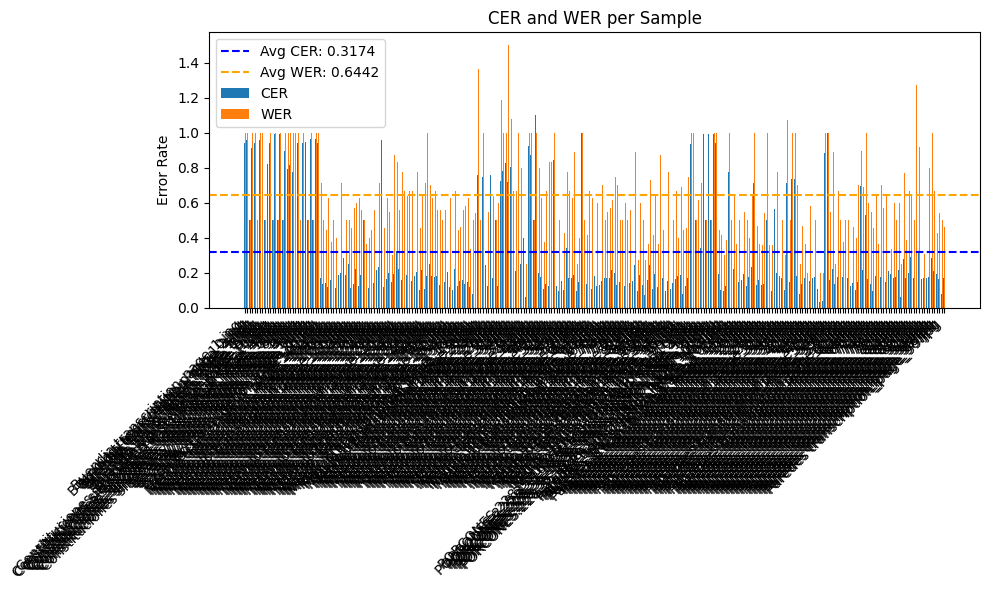

In [8]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import editdistance  # pip install editdistance
import matplotlib.pyplot as plt

# ----- Character Set & Label Conversion Utilities -----
# We use a character set covering lowercase letters (with accented characters) and digits.
# (Note: In this version we do not include a space token. You may add one if your dataset contains spaces.)
CHAR_SET = "abcdefghijklmnopqrstuvwxyzáéíóúüñ0123456789 "
# For CTC, index 0 is reserved for the blank token.
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHAR_SET)}
idx_to_char = {idx + 1: char for idx, char in enumerate(CHAR_SET)}

def text_to_labels(text):
    """Convert a string to a list of label indices."""
    return [char_to_idx[char] for char in text.lower() if char in char_to_idx]

def labels_to_text(labels):
    """Convert a list of label indices to a string."""
    return "".join([idx_to_char[label] for label in labels if label in idx_to_char])

# ----- Custom Dataset -----
class OCRDataset(data.Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        """
        Args:
            image_dir (str): Directory containing OCR images (.jpg).
            text_dir (str): Directory containing corresponding text files (.txt).
            transform: Optional torchvision transforms to apply.
        """
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform

        # List image and text files (case-insensitive).
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])
        self.text_files = sorted([f for f in os.listdir(text_dir) if f.lower().endswith('.txt')])

        print("Found image files:", self.image_files)
        print("Found text files:", self.text_files)

        if len(self.image_files) == 0 or len(self.text_files) == 0:
            raise ValueError("No files found in the given directories.")
        assert len(self.image_files) == len(self.text_files), "Mismatch between images and text files."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and convert to grayscale.
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        # Load the corresponding ground truth text.
        text_file = self.text_files[idx]
        text_path = os.path.join(self.text_dir, text_file)
        with open(text_path, 'r', encoding='utf-8') as f:
            gt_text = f.read().strip()
        label = torch.tensor(text_to_labels(gt_text), dtype=torch.long)

        return image, gt_text, label, len(label), img_file

# ----- Hybrid CNN + Transformer Model -----
class HybridOCRTransformer(nn.Module):
    def __init__(self, num_classes):
        """
        A hybrid model using a CNN backbone to extract spatial features followed by a Transformer encoder
        to model the sequence. This architecture is inspired by recent research on transformer-based OCR
        for historical texts.
        Expects input images of shape (batch, 1, 32, 128).

        Args:
            num_classes (int): Number of output classes (len(CHAR_SET) + 1 for blank).
        """
        super(HybridOCRTransformer, self).__init__()
        # CNN Backbone: extract spatial features
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (32,128) -> (32,128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         # (32,128) -> (16,64)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (16,64) -> (16,64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         # (16,64) -> (8,32)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# (8,32) -> (8,32)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)                          # (8,32) -> (4,16)
        )
        # After the CNN, feature map shape: (batch, 256, 4, 16)
        # Flatten spatial dimensions to obtain a sequence of length 4*16 = 64, with feature dimension 256.
        self.sequence_length = 4 * 16  # 64

        # Transformer Encoder for sequence modeling.
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        # Final classification layer on each time step.
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (batch, 1, 32, 128)
        features = self.cnn_backbone(x)  # -> (batch, 256, 4, 16)
        batch, C, H, W = features.size()
        # Flatten spatial dimensions: create sequence of shape (batch, H*W, C)
        features = features.view(batch, C, H * W).permute(0, 2, 1)  # (batch, 64, 256)
        # Transformer expects (sequence_length, batch, d_model)
        features = features.permute(1, 0, 2)  # (64, batch, 256)
        encoded = self.transformer_encoder(features)  # (64, batch, 256)
        encoded = encoded.permute(1, 0, 2)  # (batch, 64, 256)
        logits = self.fc(encoded)  # (batch, 64, num_classes)
        return logits

# ----- Greedy Decoder for CTC Outputs -----
def greedy_decoder(output, blank=0):
    """
    Decodes the raw output logits of shape (T, B, num_classes)
    into predicted text strings for each batch element.
    """
    # Compute argmax over classes at each time step.
    arg_maxes = torch.argmax(output, dim=2)  # (T, B)
    decoded_preds = []
    for args in arg_maxes.transpose(0, 1):  # iterate over batch
        pred = []
        prev = blank
        for idx in args:
            idx = idx.item()
            if idx != prev and idx != blank:
                pred.append(idx)
            prev = idx
        decoded_preds.append(labels_to_text(pred))
    return decoded_preds

# ----- Collate Function for DataLoader -----
def ocr_collate_fn(batch):
    images, texts, labels, label_lengths, filenames = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    labels_concat = torch.cat(labels)
    return images, texts, labels_concat, label_lengths, filenames

# ----- Main Training and Evaluation Routine -----
def train_and_evaluate(image_dir, text_dir, img_height=32, img_width=128,
                       num_epochs=100, batch_size=8, learning_rate=0.0005):
    """
    This routine trains the hybrid CNN+Transformer model using CTC loss.
    After training, it computes the character error rate (CER) and word error rate (WER)
    for each sample and then plots the results.
    """
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),  # scales pixel values to [0,1]
    ])

    dataset = OCRDataset(image_dir, text_dir, transform=transform)
    train_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=ocr_collate_fn)

    num_classes = len(CHAR_SET) + 1  # +1 for the blank token
    model = HybridOCRTransformer(num_classes=num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # CTC Loss expects raw logits.
    ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting training of the hybrid CNN+Transformer model...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (images, _, labels, label_lengths, _) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # (batch, sequence, num_classes)
            outputs = outputs.permute(1, 0, 2)  # (sequence, batch, num_classes)
            batch_size_actual = images.size(0)
            input_lengths = torch.full(size=(batch_size_actual,), fill_value=outputs.size(0), dtype=torch.long)

            loss = ctc_loss(outputs, labels, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss/len(train_loader):.4f}\n")

    torch.save(model.state_dict(), "hybrid_ocr_transformer.pth")
    print("Training complete and model saved as 'hybrid_ocr_transformer.pth'.\n")

    # Evaluate the model on individual samples using CER/WER and plot results.
    eval_loader = data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=ocr_collate_fn)
    print("Evaluating model on individual samples (CER & WER):")
    evaluate_samples_and_plot(model, eval_loader, device)

# ----- Example Usage -----
if __name__ == "__main__":
    # Set these directories to point to your OCR images (JPG) and ground truth texts (TXT).
    image_directory = "/content/ocr_images"  # Directory containing .jpg files.
    text_directory = "/content/ocr_texts"      # Directory containing corresponding .txt files.

    # Adjust hyperparameters as needed. Here we use 100 epochs for demonstration.
    train_and_evaluate(image_directory, text_directory, img_height=32, img_width=128,
                       num_epochs=100, batch_size=8, learning_rate=0.0005)
